In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
from cpymad.madx import Madx
import xtrack as xt


/Users/giadarol/xsuite_packages/xtrack/xtrack/progress_indicator.py:95: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
mad = Madx()
mad.call('PIMM.seq')
mad.beam()
mad.use('pimms')


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.00  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2023.05.05               +
  + Execution date: 2024.02.03 13:18:30      +
  ++++++++++++++++++++++++++++++++++++++++++++
mb:  sbend, l=1.661, angle=0.3926990817, e1=0.19634954085, e2=0.19634954085;

qf1: quadrupole, l=2*0.175, k1:= kqf1;

qd:  quadrupole, l=2*0.175, k1:= kqd;

qf2: quadrupole, l=2*0.175, k1:= kqf2;



kqf1 := kqf;

kqf2 := kqf;



sd1: sextupole, l=0.2, k2:=ksd;

sf1: sextupole, l=0.2, k2:=ksf;

sd2: sextupole, l=0.2, k2:=ksd;

sf2: sextupole, l=0.2, k2:=ksf;

se1: sextupole, l=0.2, k2:=kse1;

se2: sextupole, l=0.2, k2:=kse2;



pimms:sequence,refer=centre,l=75.24;

              qf1.1: qf1, at=2.3875;

              mb, at=3.8125;

              qd.1: qd, at=5.2925;

              mb, at=7.0475;

              qf1.2: qf1, at=8.3275;

              sd1, at=10.29;

              qf2.1: qf2, at=10.6775;

       

In [4]:
line = xt.Line.from_madx_sequence(mad.sequence.pimms, deferred_expressions=True)
line.particle_ref = xt.Particles(q0=1, mass0=xt.PROTON_MASS_EV, kinetic_energy0=120e6)

Converting sequence "pimms":   0%|          | 0/96 [00:00<?, ?it/s]

In [5]:
sv = line.survey()

<IPython.core.display.Javascript object>


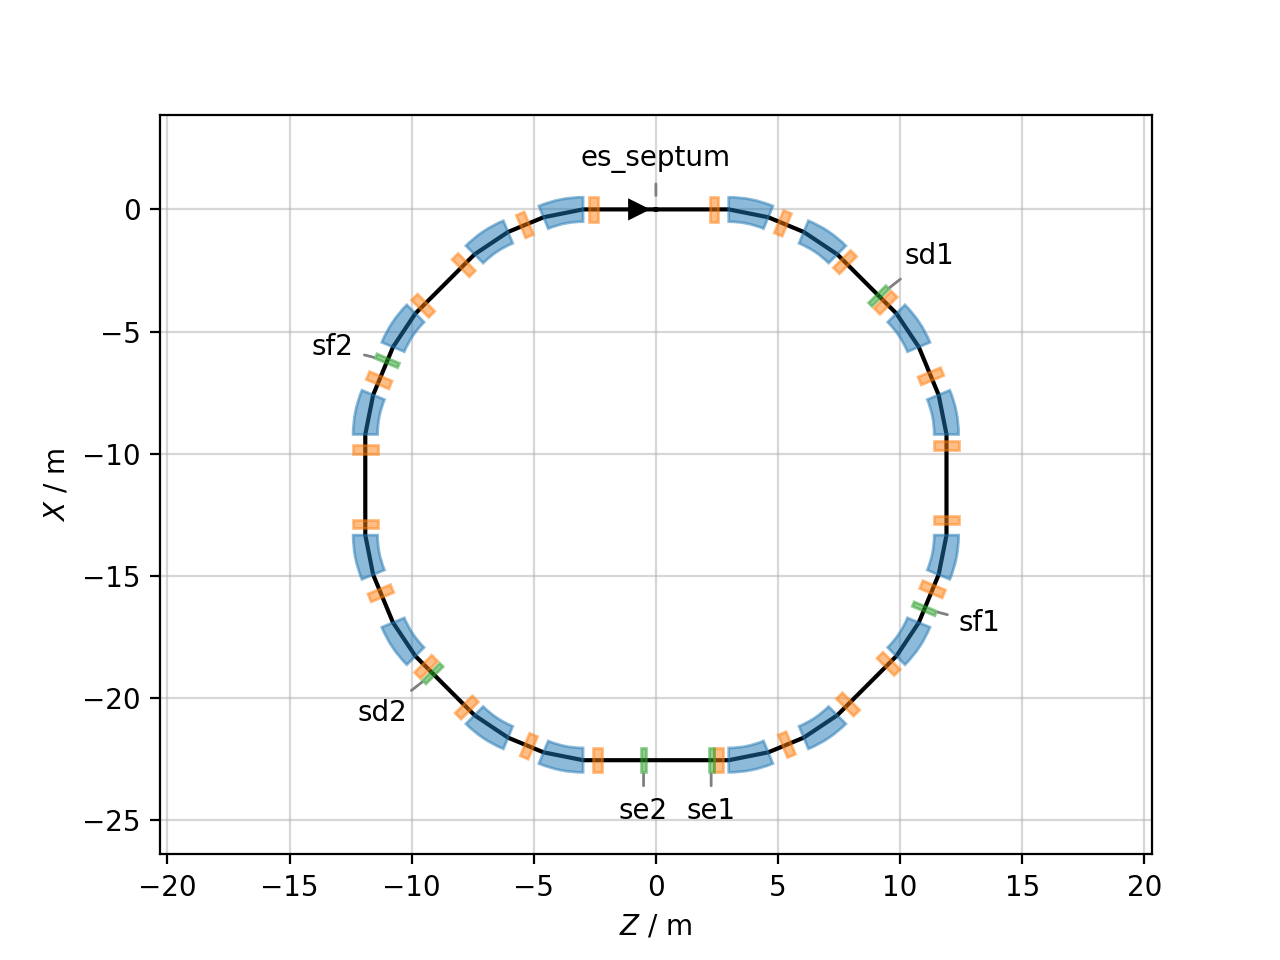

In [6]:
import xplt
tt = line.get_table()
ttsext = tt.rows[tt.element_type == 'Sextupole']
xplt.FloorPlot(sv, line, labels=['es_septum'] + list(ttsext.name))

In [7]:
line.vars['kqf'] = 2e-2
line.vars['kqd'] = -2e-2

In [8]:
tw0 = line.twiss(method='4d')

Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


In [9]:
opt = line.match(
    solve=False,
    method='4d',
    vary=[
        xt.Vary('kqf', limits=(0, 1),  step=1e-3, tag='qf'),
        xt.Vary('kqd', limits=(-1, 0), step=1e-3, tag='qd'),
        
    ],
    targets=[
        xt.TargetSet(qx=1.6, qy=1.72, tol=1e-6, tag='tunes'),
    ]
)
opt.step(20)

In [10]:
opt.target_status()

Target status:                   
id state tag   tol_met      residue current_val target_val description                         
 0 ON    tunes    True -3.75832e-07         1.6        1.6 'qx', val=1.6, tol=1e-06, weight=10 
 1 ON    tunes    True  1.41825e-07        1.72       1.72 'qy', val=1.72, tol=1e-06, weight=10


In [11]:
opt = line.match(
    solve=False,
    method='4d',
    vary=[
        xt.VaryList(['kqf1', 'kqf2'], limits=(0, 1),  step=1e-3, tag='qf'),
        xt.Vary('kqd', limits=(-1, 0), step=1e-3, tag='qd'),
        
    ],
    targets=[
        xt.TargetSet(qx=1.6, qy=1.72, tol=1e-6),
        xt.Target(dx = 0, at='es_septum', tol=1e-6)
    ]
)
opt.step(20)

In [12]:
opt.target_status()

Target status:                   
id state tag tol_met      residue current_val target_val description                                 
 0 ON           True  3.42545e-10         1.6        1.6 'qx', val=1.6, tol=1e-06, weight=10         
 1 ON           True -6.07897e-10        1.72       1.72 'qy', val=1.72, tol=1e-06, weight=10        
 2 ON           True  5.02764e-09 5.02764e-09          0 ('dx', 'es_septum'), val=0, tol=1e-06, w ...


In [13]:
opt.vary_status()

Vary status:                 
id state tag name lower_limit current_val upper_limit val_at_iter_0  step weight
 0 ON    qf  kqf1           0     0.28646           1      0.396494 0.001      1
 1 ON    qf  kqf2           0    0.520847           1      0.396494 0.001      1
 2 ON    qd  kqd           -1    -0.51041           0     -0.510996 0.001      1


<IPython.core.display.Javascript object>


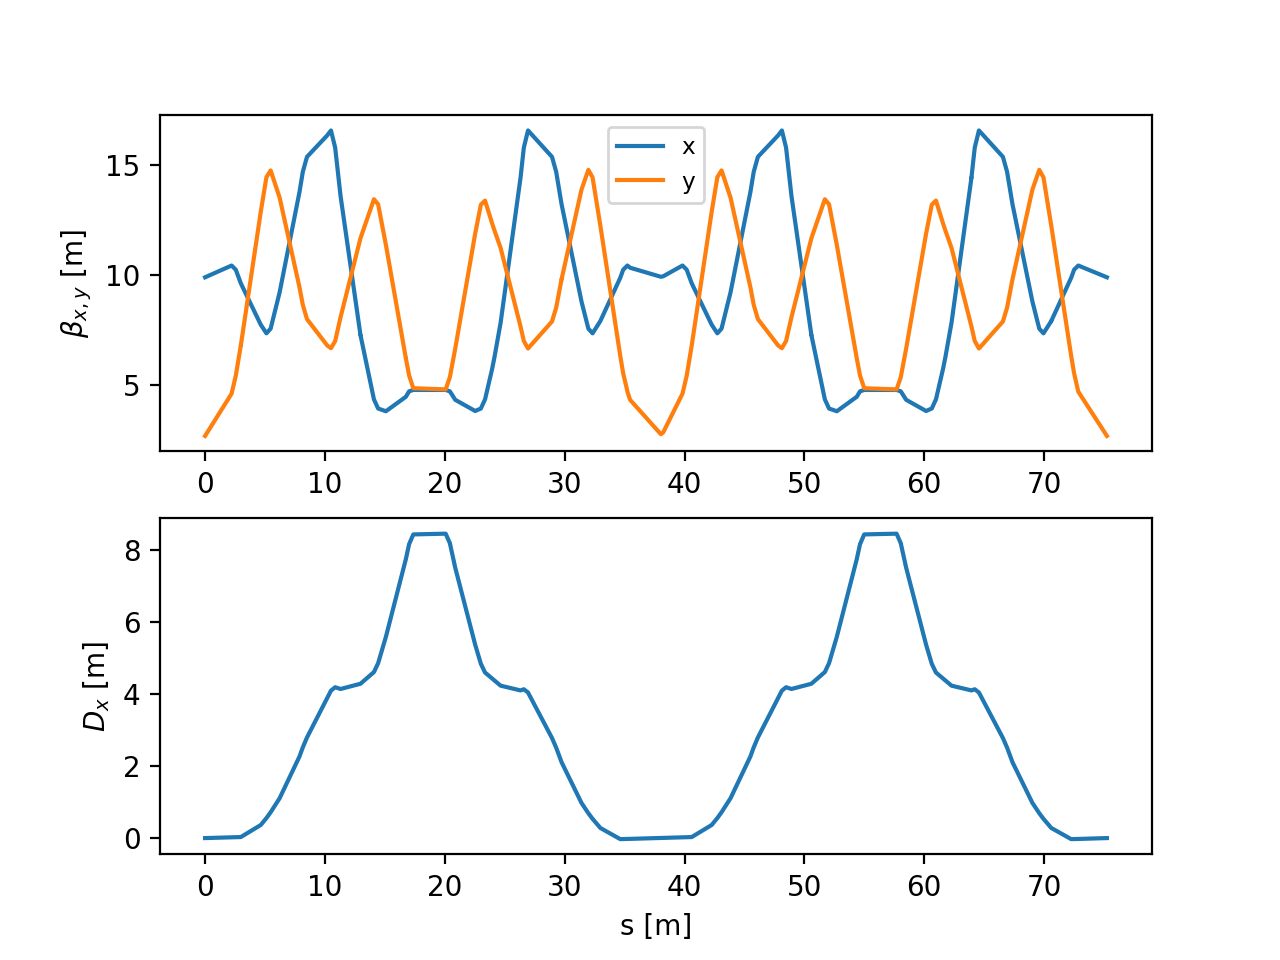

Text(0.5, 0, 's [m]')

In [20]:
tw = line.twiss(method='4d')

plt.figure(3)
ax1 = plt.subplot(2, 1, 1)
plt.plot(tw.s, tw.betx, '-', label='x')
plt.plot(tw.s, tw.bety, '-', label='y')
plt.ylabel(r'$\beta_{x,y}$ [m]')
plt.legend(fontsize='small')

plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(tw.s, tw.dx, '-', label='x')
plt.ylabel(r'$D_x$ [m]')
plt.xlabel('s [m]')